In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import scipy.sparse as sp
import anndata as ad
from scipy import sparse
import pynndescent

warnings.filterwarnings('ignore')

In [3]:
import sys, importlib

for k in list(sys.modules.keys()):
    if k == "mapping_sc_to_st" or k.startswith("mapping_sc_to_st"):
        del sys.modules[k]

import mapping_sc_to_st

# Data Import

In [11]:
## Hyperparameter
st_time = '75'
st_batch = 'E1'
use_sc_data = 'mc' # 'sc' or 'mc'
use_sc_data_time_point = (7, 9) # 50p = (5, 5.67), 75p = (8.0, 8.4), 6s = (11.5, 12.4)
exclude_st_cell_region = ['YSL', 'Dorsal Forerunner Cells', 'Primordial Germ Cells']

## file path
path_st = '/local/users/mmittnenzweig/spatiotemporal_zebrafish/data/weMerfish/AnnData_withImputation/'
path_mc = '/local/users/dlee/ST/data/timecourse_wt/timecourse_wt.metacells_celltypes-distance-2025-11-19.h5ad'
path_sc = '/local/users/dlee/ST/data/timecourse_wt/timecourse_wt.cells_celltypes-2025-11-19.h5ad'
metacell_graph = '/local/users/dlee/ST/data/cell_type_mgraph.csv'
cell_color_path = '/local/users/dlee/ST/data/cell_type_colors-2025-11-19.csv'

cell_type_color = pd.read_csv(cell_color_path)

In [55]:
adata_sc = sc.read_h5ad(path_sc)
adata_mc = sc.read_h5ad(path_mc)
    
if st_time == '50':
    adata_st = sc.read_h5ad(path_st + 'A_50p_' + st_batch + '_with_imputation.h5ad')
elif st_time == '75':
    adata_st = sc.read_h5ad(path_st + 'B_75p_' + st_batch + '_with_imputation.h5ad')
else:
    adata_st = sc.read_h5ad(path_st + 'C_6s_' + st_batch + '_with_imputation_rescaled_z.h5ad')

In [56]:
sc_mask = adata_sc.obs['developmental_time'].between(*use_sc_data_time_point, inclusive='both')
adata_sc = adata_sc[sc_mask, :].copy()

st_mask = ~adata_st.obs["clusters"].isin(exclude_st_cell_region)
adata_st = adata_st[st_mask, :].copy()

adata_sc, _ = mapping_sc_to_st.prep.filter_small_celltypes(
    adata_sc,
    groupby="cell_type",
    min_cells=50,
)

too small groups: ['unclear', 'Neural plate border', 'Blastomeres_foxo3b', 'PGC', 'Prechordal plate (axial mesoderm) late', 'Ventral_margin_early', 'Forebrain ventral', 'Intermediate mesoderm', 'Blastomeres_50p_sagb', 'Hindbrain 1', 'Outliers', 'Epidermal ectoderm', 'Telencephalon dorsal', 'Midbrain', 'Blastomeres_dorsal', 'Hindbrain 2', 'Placode otic']


In [57]:
all_cell_types = adata_sc.obs["cell_type"].astype(str).unique()
mask = adata_mc.obs["cell_type"].astype(str).isin(all_cell_types).to_numpy()
adata_mc = adata_mc[mask, :].copy()

In [62]:
sc.pp.filter_genes(adata_sc, min_cells=30)

sc.pp.highly_variable_genes(
    adata_sc,
    layer="counts",
    flavor="seurat_v3",
    n_top_genes=6000,    
    batch_key= None,  
    subset=False,
    inplace=True
)

In [63]:
print("HVG selected:", int(adata_sc.var["highly_variable"].sum()))

HVG selected: 6000


In [64]:
adata_hvg = adata_sc[:, adata_sc.var["highly_variable"]].copy()

In [65]:
_ = mapping_sc_to_st.prep.ensure_all_basic(
    adata_hvg,
    adata_st,
    st_xy_cols=None,     

    make_spatial_normed=True,   
    spatial_k=10,

    make_scvi=True,            
    scvi_batch_key=None,    
    scvi_counts_layer="counts", 
    scvi_n_latent=512, # 512, 768 or 1024 ## try all 3 of them 
    scvi_max_epochs=100,

    make_scvi_st=False, 
    model_device = 'gpu',
    accelerator = 'gpu',
    devices = [3]
)

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


start make_scvi


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [66]:
adata_sc.obsm['X_scvi'] = adata_hvg.obsm['X_scvi']

In [68]:
adata_sc.write("/local/users/dlee/ST/data/scvi_sc_embedding/timecourse_wt_time_7to9_6000_HVG_512_layer_150_epoch.h5ad")

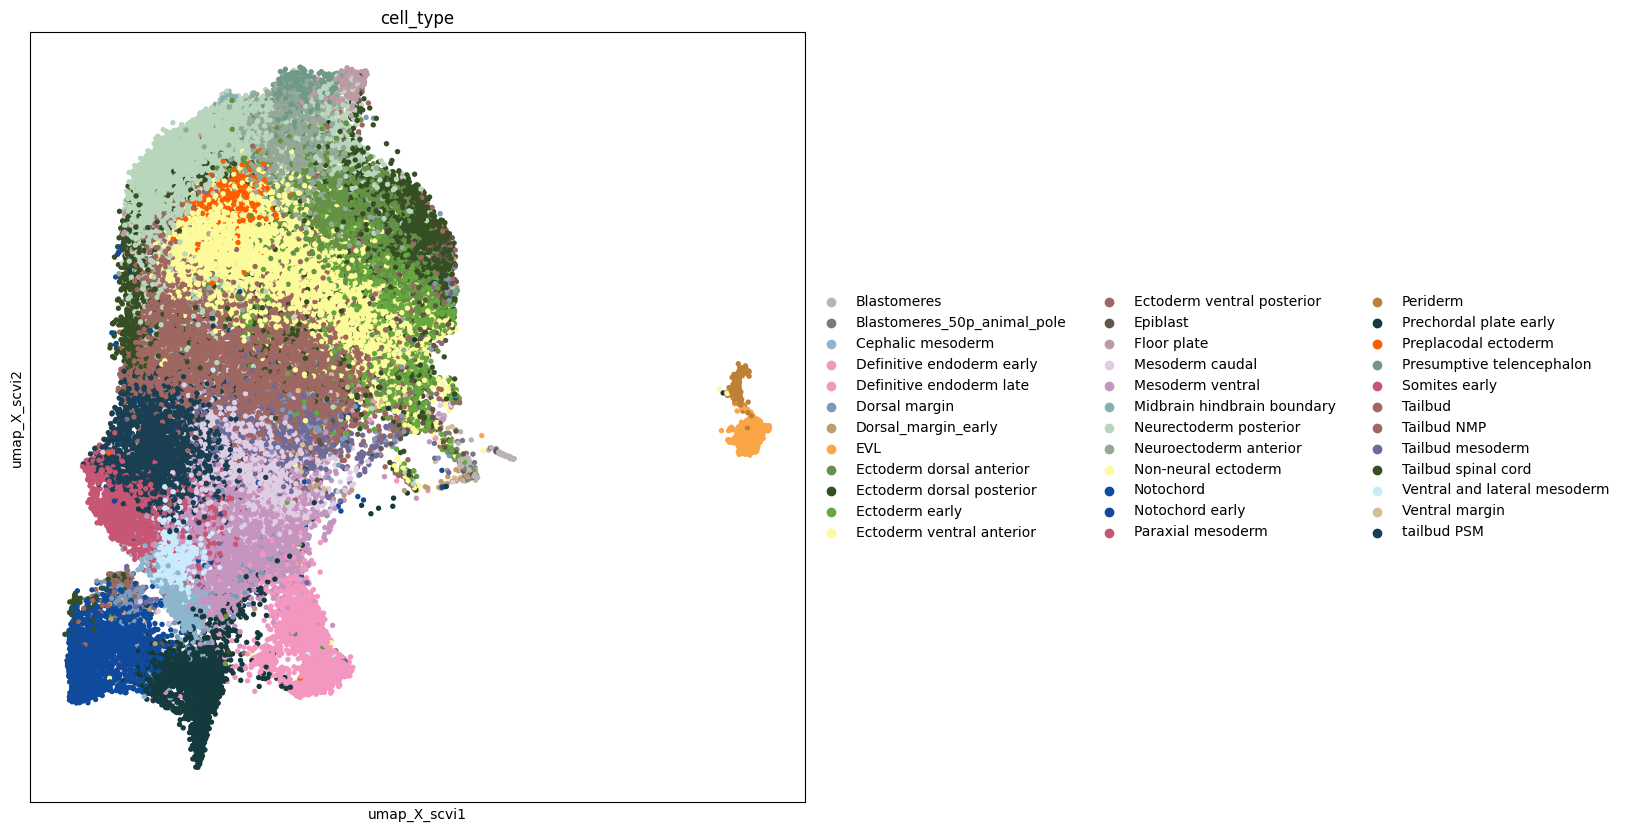

In [104]:
_ = mapping_sc_to_st.fig.plot_rep_umap_pca(adata_sc, color_df = cell_type_color, do_pca = False)

In [4]:
adata_sc = sc.read_h5ad("/local/users/dlee/ST/data/scvi_sc_embedding/timecourse_wt_time_7to9_6000_HVG_512_layer_150_epoch.h5ad")

In [7]:
def make_metacell(
    adata,
    # ---- key / io ----
    rep_key="X_scvi",
    celltype_key="auto",          
    obs_key="metacell",
    layer="auto",                 
    expr_mode="mean",             
    drop_unassigned=True,        
    # ---- grouping params ----
    target_size=20,
    min_size=10,
    max_dist="auto",              
    attach_dist="auto",          
    n_neighbors=80,
    # auto distance quantile
    auto_dist_k=None,            
    auto_dist_quantile=0.85,      
    # ---- runtime ----
    random_state=42,
    attach_batch_size=4096,
    # ---- leftover force-assign ----
    force_assign_leftover=True,   
    force_ignore_size_limit=True, 
    # ---- misc ----
    store_member_cells=True      
):
    """
    Returns
    -------
    metacell_id : np.ndarray[int32], shape (n_cells,)
    info        : dict
    mc_adata    : AnnData (metacell-level)
    """

    X = np.asarray(adata.obsm[rep_key], dtype=np.float32, order="C")
    n_cells, n_dim = X.shape


    if celltype_key == "auto":
        ct_candidates = ["cell_type", "celltype", "CellType", "annotation", "annot", "label", "labels"]
        celltype_key_used = next((k for k in ct_candidates if k in adata.obs.columns), None)
    else:
        celltype_key_used = celltype_key


    if layer == "auto":
        layer_used = "counts" if "counts" in adata.layers.keys() else None
    else:
        layer_used = layer

    M = adata.layers[layer_used] if layer_used is not None else adata.X


    n_neighbors = int(min(max(n_neighbors, target_size), n_cells))
    min_size = int(min(min_size, target_size))
    if min_size < 1:
        min_size = 1

    # ---------------------------
    # 1) ANN graph (pynndescent)
    # ---------------------------
    index = pynndescent.NNDescent(
        X,
        n_neighbors=n_neighbors,
        metric="euclidean",
        random_state=random_state
    )
    inds, dists = index.neighbor_graph  # (n_cells, n_neighbors)


    if auto_dist_k is None:
        auto_dist_k = int(target_size)
    auto_dist_k = int(min(max(auto_dist_k, 1), dists.shape[1] - 1))

    auto_max = float(np.quantile(dists[:, auto_dist_k], auto_dist_quantile))

    if max_dist == "auto":
        max_dist_used = auto_max
    else:
        max_dist_used = float(max_dist)

    if attach_dist == "auto":
        attach_dist_used = max_dist_used
    else:
        attach_dist_used = float(attach_dist)


    rng = np.random.default_rng(random_state)
    seeds = np.arange(n_cells, dtype=np.int32)
    rng.shuffle(seeds)

    unassigned = np.ones(n_cells, dtype=bool)
    metacell_id = np.full(n_cells, -1, dtype=np.int32)
    group_members = []
    gid = 0

    for seed in seeds:
        if not unassigned[seed]:
            continue

        neigh = inds[seed]
        dist = dists[seed]

        cand = neigh[(dist <= max_dist_used) & (unassigned[neigh])]

        if unassigned[seed] and (seed not in cand):
            cand = np.concatenate([[seed], cand])

        cand = np.unique(cand)

        if cand.size < min_size:
            continue

        grp = cand[:target_size]
        metacell_id[grp] = gid
        unassigned[grp] = False
        group_members.append(grp.tolist())
        gid += 1

    if gid > 0:
        centroids = np.vstack([X[np.array(g)].mean(axis=0) for g in group_members]).astype(np.float32)
        group_sizes = np.array([len(g) for g in group_members], dtype=np.int32)

        leftover = np.where(metacell_id == -1)[0]
        if leftover.size > 0:
            bsz = int(max(256, attach_batch_size))
            for s in range(0, leftover.size, bsz):
                idx = leftover[s:s+bsz]
                Y = X[idx]  # (b, d)

                # squared euclidean
                y2 = np.sum(Y * Y, axis=1, keepdims=True)
                c2 = np.sum(centroids * centroids, axis=1)[None, :]
                dist2 = y2 + c2 - 2.0 * (Y @ centroids.T)
                np.maximum(dist2, 0, out=dist2)

                best_g = np.argmin(dist2, axis=1)
                best_d = np.sqrt(dist2[np.arange(dist2.shape[0]), best_g])

                for cell_i, g, d in zip(idx, best_g, best_d):
                    if (d <= attach_dist_used) and (group_sizes[g] < target_size):
                        metacell_id[cell_i] = int(g)
                        group_members[g].append(int(cell_i))
                        group_sizes[g] += 1
    else:
        group_sizes = np.array([], dtype=np.int32)

    if force_assign_leftover and gid > 0:
        still_left = np.where(metacell_id == -1)[0]
        if still_left.size > 0:
            centroids = np.vstack([
                X[np.array(g, dtype=np.int32)].mean(axis=0) for g in group_members
            ]).astype(np.float32)

            group_sizes = np.array([len(g) for g in group_members], dtype=np.int32)

            bsz = int(max(256, attach_batch_size))
            for s in range(0, still_left.size, bsz):
                idx = still_left[s:s+bsz]
                Y = X[idx]  # (b, d)

                # squared euclidean
                y2 = np.sum(Y * Y, axis=1, keepdims=True)
                c2 = np.sum(centroids * centroids, axis=1)[None, :]
                dist2 = y2 + c2 - 2.0 * (Y @ centroids.T)
                np.maximum(dist2, 0, out=dist2)

                order = np.argsort(dist2, axis=1)

                for r, cell_i in enumerate(idx):
                    assigned = False
                    for g in order[r]:
                        g = int(g)
                        if force_ignore_size_limit or (group_sizes[g] < target_size):
                            metacell_id[cell_i] = g
                            group_members[g].append(int(cell_i))
                            group_sizes[g] += 1
                            assigned = True
                            break
                    if not assigned:
                        pass


    adata.obs[obs_key] = pd.Categorical(metacell_id.astype(str))

    valid_mask = (metacell_id >= 0) if drop_unassigned else np.ones(n_cells, dtype=bool)
    ids = metacell_id[valid_mask]

    if ids.size == 0:
        mc_adata = ad.AnnData(
            X=np.zeros((0, adata.n_vars), dtype=np.float32),
            obs=pd.DataFrame(index=[]),
            var=adata.var.copy()
        )
        mc_adata.obsm[rep_key] = np.zeros((0, n_dim), dtype=np.float32)

        info = {
            "n_groups": int(gid),
            "n_metacells_in_mcadata": 0,
            "unassigned": int((metacell_id == -1).sum()),
            "mean_group_size": float(group_sizes.mean()) if group_sizes.size else 0.0,
            "group_size_min": int(group_sizes.min()) if group_sizes.size else 0,
            "group_size_max": int(group_sizes.max()) if group_sizes.size else 0,
            "rep_key": rep_key,
            "celltype_key_used": celltype_key_used,
            "obs_key": obs_key,
            "layer_used": layer_used,
            "expr_mode": expr_mode,
            "target_size": int(target_size),
            "min_size": int(min_size),
            "n_neighbors": int(n_neighbors),
            "max_dist_used": float(max_dist_used),
            "attach_dist_used": float(attach_dist_used),
            "auto_dist_k": int(auto_dist_k),
            "auto_dist_quantile": float(auto_dist_quantile),
            "random_state": int(random_state),
            "drop_unassigned": bool(drop_unassigned),
            "force_assign_leftover": bool(force_assign_leftover),
            "force_ignore_size_limit": bool(force_ignore_size_limit),
        }
        adata.uns["metacell_info"] = info
        return metacell_id, info, mc_adata

    uniq = np.unique(ids)
    gid_to_row = {g: i for i, g in enumerate(uniq)}
    row_idx = np.array([gid_to_row[g] for g in ids], dtype=np.int32)

    n_mc = len(uniq)
    counts = np.bincount(row_idx, minlength=n_mc).astype(np.int32)

    Mv = M[valid_mask]
    if sparse.issparse(Mv):
        membership = sparse.csr_matrix(
            (np.ones(len(row_idx), dtype=np.float32),
             (row_idx, np.arange(len(row_idx), dtype=np.int32))),
            shape=(n_mc, len(row_idx))
        )
        mc_sum = membership @ Mv
        if expr_mode == "mean":
            inv = 1.0 / np.maximum(counts, 1)
            mc_expr = sparse.diags(inv.astype(np.float32)) @ mc_sum
        else:
            mc_expr = mc_sum
    else:
        Mv = np.asarray(Mv, dtype=np.float32)
        mc_sum = np.zeros((n_mc, adata.n_vars), dtype=np.float32)
        for i in range(n_mc):
            idx = np.where(row_idx == i)[0]
            mc_sum[i] = Mv[idx].sum(axis=0)
        mc_expr = mc_sum / np.maximum(counts[:, None], 1) if expr_mode == "mean" else mc_sum

    Xv = X[valid_mask]
    mc_scvi = np.zeros((n_mc, n_dim), dtype=np.float32)
    for i in range(n_mc):
        idx = np.where(row_idx == i)[0]
        mc_scvi[i] = Xv[idx].mean(axis=0)

    # dominant cell type
    if celltype_key_used is not None:
        ctv = adata.obs[celltype_key_used].astype(str).values[valid_mask]
        dom_ct, dom_frac = [], []
        for i in range(n_mc):
            idx = np.where(row_idx == i)[0]
            vc = pd.Series(ctv[idx]).value_counts()
            dom_ct.append(vc.index[0])
            dom_frac.append(float(vc.iloc[0] / vc.sum()))
    else:
        dom_ct = ["unknown"] * n_mc
        dom_frac = [np.nan] * n_mc

    mc_obs = pd.DataFrame({
        "metacell_id_original": uniq.astype(int),
        "n_cells": counts,
        "cell_type": dom_ct,
        "dominant_cell_type_frac": dom_frac
    }, index=[f"MC_{int(g)}" for g in uniq])

    mc_adata = ad.AnnData(X=mc_expr, obs=mc_obs, var=adata.var.copy())
    mc_adata.obsm[rep_key] = mc_scvi

    if store_member_cells:
        valid_cells = np.where(valid_mask)[0]
        member_cells = {}
        for i, g in enumerate(uniq):
            member_cells[f"MC_{int(g)}"] = valid_cells[np.where(row_idx == i)[0]].tolist()
        mc_adata.uns["member_cells"] = member_cells

    info = {
        "n_groups": int(gid),
        "n_metacells_in_mcadata": int(n_mc),
        "unassigned": int((metacell_id == -1).sum()),
        "mean_group_size": float(group_sizes.mean()) if group_sizes.size else 0.0,
        "group_size_min": int(group_sizes.min()) if group_sizes.size else 0,
        "group_size_max": int(group_sizes.max()) if group_sizes.size else 0,
        "rep_key": rep_key,
        "celltype_key_used": celltype_key_used,
        "obs_key": obs_key,
        "layer_used": layer_used,
        "expr_mode": expr_mode,
        "target_size": int(target_size),
        "min_size": int(min_size),
        "n_neighbors": int(n_neighbors),
        "max_dist_used": float(max_dist_used),
        "attach_dist_used": float(attach_dist_used),
        "auto_dist_k": int(auto_dist_k),
        "auto_dist_quantile": float(auto_dist_quantile),
        "random_state": int(random_state),
        "drop_unassigned": bool(drop_unassigned),
        "force_assign_leftover": bool(force_assign_leftover),
        "force_ignore_size_limit": bool(force_ignore_size_limit),
        "store_member_cells": bool(store_member_cells),
    }

    adata.uns["metacell_info"] = info
    return metacell_id, info, mc_adata


In [8]:
cluster_id, info, cluster_adata = make_metacell(
    adata_sc,
    target_size=15,
    min_size=5,
    max_dist="auto",      
    attach_dist="auto",  
    n_neighbors= 300,
    obs_key="metacell20_r",
    celltype_key="cell_type", 
    layer="auto",         
    expr_mode="mean",
    auto_dist_quantile=0.8,
    force_assign_leftover=True,      
    force_ignore_size_limit=True     
)

In [9]:
info

{'n_groups': 6722,
 'n_metacells_in_mcadata': 6722,
 'unassigned': 0,
 'mean_group_size': 14.530199345432907,
 'group_size_min': 5,
 'group_size_max': 48,
 'rep_key': 'X_scvi',
 'celltype_key_used': 'cell_type',
 'obs_key': 'metacell20_r',
 'layer_used': 'counts',
 'expr_mode': 'mean',
 'target_size': 15,
 'min_size': 5,
 'n_neighbors': 300,
 'max_dist_used': 7.698375225067139,
 'attach_dist_used': 7.698375225067139,
 'auto_dist_k': 15,
 'auto_dist_quantile': 0.8,
 'random_state': 42,
 'drop_unassigned': True,
 'force_assign_leftover': True,
 'force_ignore_size_limit': True,
 'store_member_cells': True}

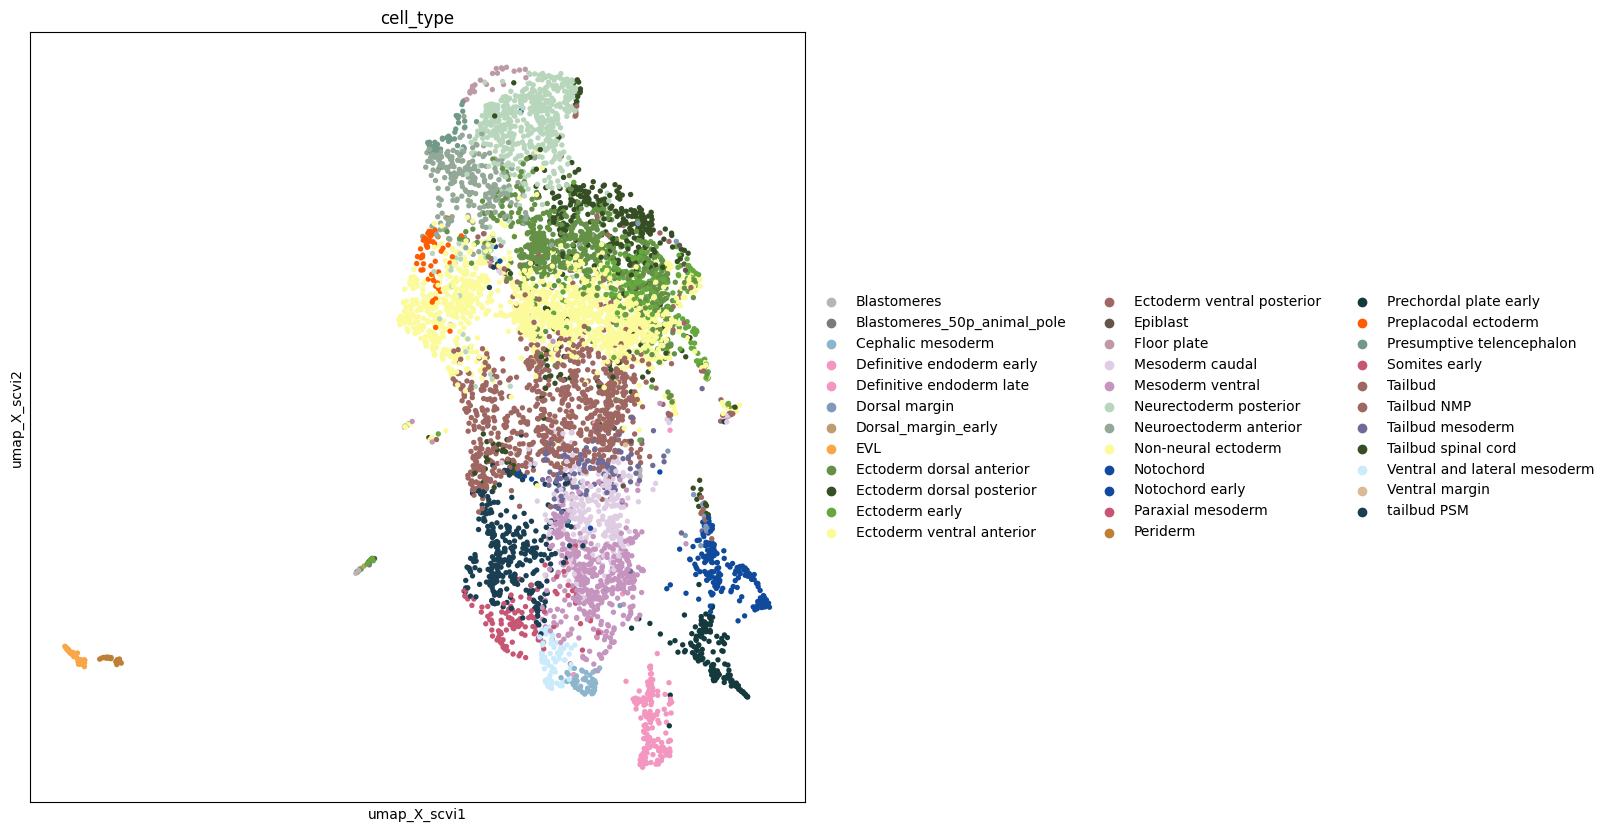

In [12]:
_ = mapping_sc_to_st.fig.plot_rep_umap_pca(cluster_adata, color_df = cell_type_color, do_pca = False)

In [ ]:
cluster_adata.write("/local/users/dlee/ST/data/timecourse_wt/make_small_clusters_10_3_100.h5ad")